In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
from scipy.optimize import curve_fit

Start import
Working on midway2-0416.rcc.local with the following versions 
and installation paths:
strax
	v0.15.2	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.4	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenon1t_dali()

In [3]:
run_Rn = '170314_0419'
run_Kr = '170206_1355'
run_Ar = '181027_0841'
run_bkg = '170204_1610'

In [4]:
def plot_area_width_aft(run_id, low = 0, high = 7, low2 = 0, high2 = 1, binning = 500,title='Kr-83m run'):
    events = st.get_array(run_id,'event_info')
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_cs1 = Histdd(events['cs1'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_cs2 = Histdd(events['cs2'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_area'], events['s1_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'{title}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    ph_cs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_cs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'{title}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'{title}')
    plt.xscale('log')

Loading event_info: |          | 0.00 % [00:00<?]

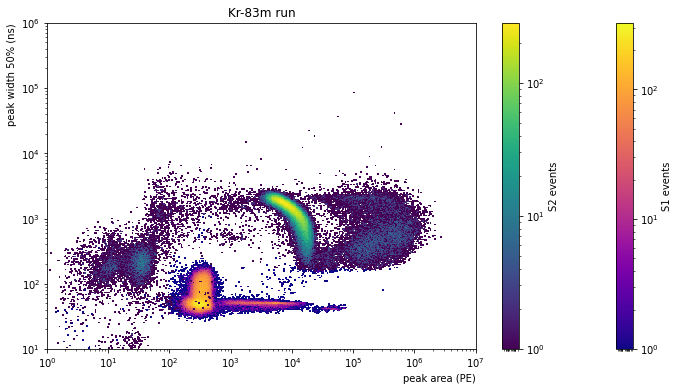

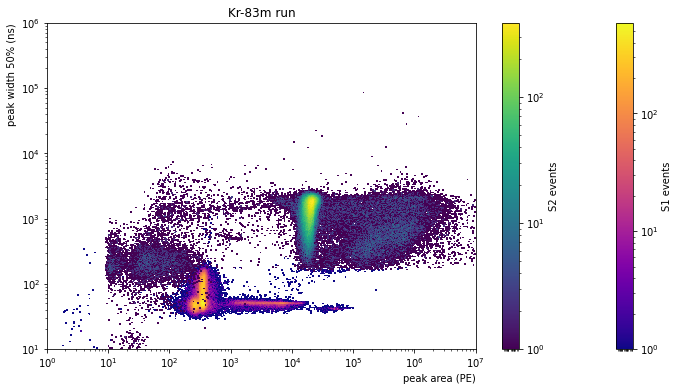

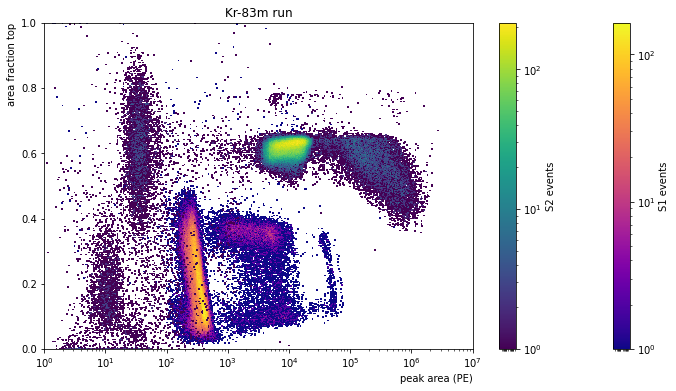

In [5]:
plot_area_width_aft(run_Kr)

Loading event_info: |          | 0.00 % [00:00<?]

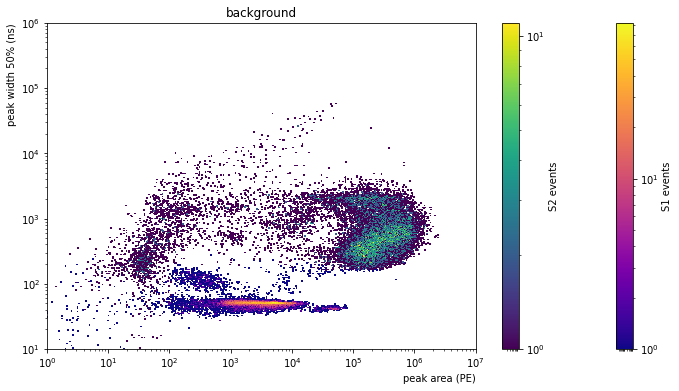

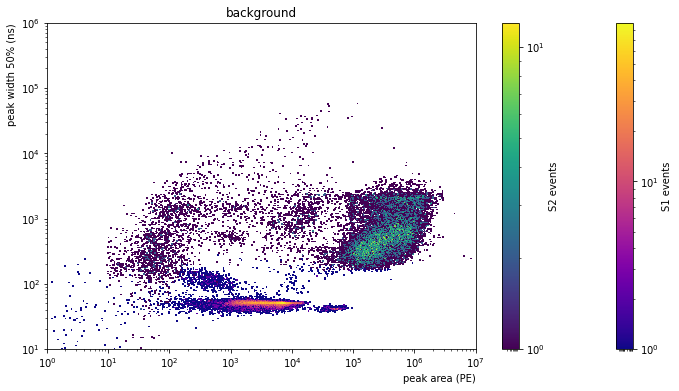

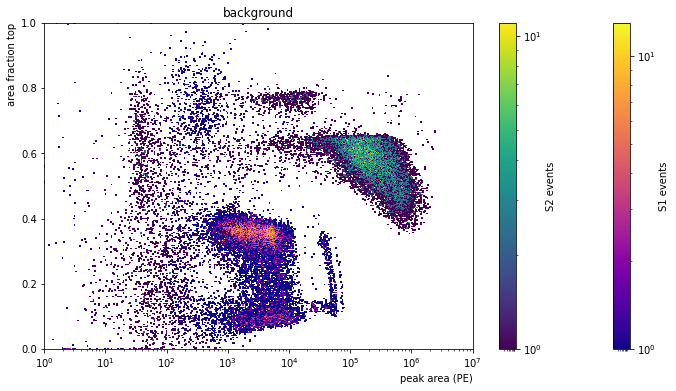

In [6]:
plot_area_width_aft(run_bkg,title='background')

In [7]:
def plot_drift_time(run, bins = 300,title='Kr-83m run'):
    events = st.get_array(run,'event_info')
    phd = Histdd(events['drift_time']/1000, events['s2_area'],
                bins=(np.linspace(0, 800, bins), np.linspace(0, 35000, bins)))
    phw = Histdd(events['drift_time']/1000, events['s2_range_50p_area'],
                bins=(np.linspace(0, 800, bins), np.logspace(1, 4, bins)))
    plt.figure(figsize=(12,6))
    phd.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    #plt.yscale('log')
    
    plt.figure(figsize=(12,6))
    phw.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    plt.yscale('log')

Loading event_info: |          | 0.00 % [00:00<?]

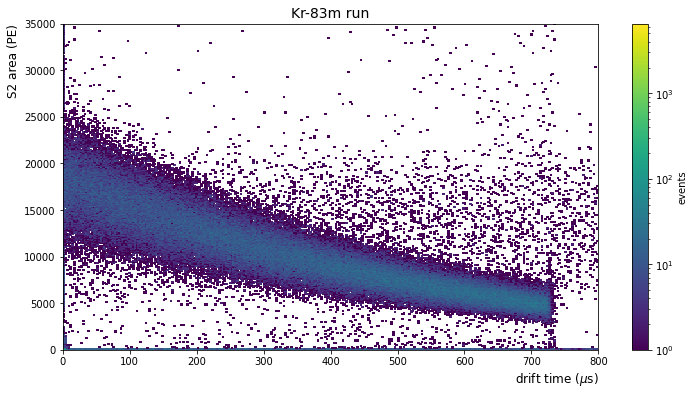

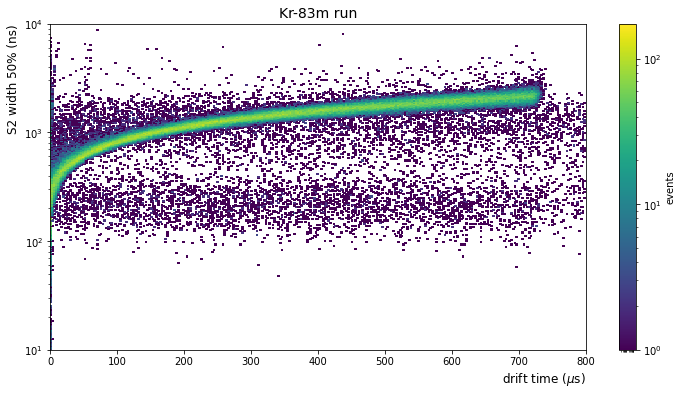

In [8]:
plot_drift_time(run_Kr)

In [9]:
def plot_drift_time_aft(run, low = 0, high = 800, low2 = 0, high2 = 1, binning = 500,title='Kr-83m run'):
    events = st.get_array(run,'event_info')
    pha1 = Histdd(events['drift_time']/1000, events['s1_area_fraction_top'],
                bins=(np.linspace(low, high, binning), np.linspace(low2, high2, binning)))
    pha2 = Histdd(events['drift_time']/1000, events['s2_area_fraction_top'],
                bins=(np.linspace(low, high, binning), np.linspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    pha1.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S1 area fraction top", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    
    #plt.figure(figsize=(12,6))
    #pha2.plot(log_scale=True, cblabel='events')
    #plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    #plt.ylabel("S2 area fraction top", ha='right', y=1,fontsize=12)
    #plt.title(f'run {run_id}',fontsize=14)

Loading event_info: |          | 0.00 % [00:00<?]

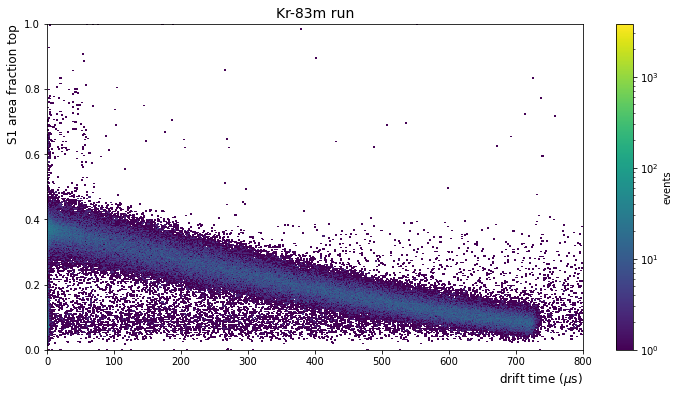

In [10]:
plot_drift_time_aft(run_Kr)

In [11]:
def expo(t, tau, A):
    return A * np.exp(-t/tau)

def electron_lifetime(run, bins=100, width_cut=4000, area_cut = (1,25000),
                      dt_cut = 700, title='Kr-83m run'):
    events = st.get_array(run,'event_info')
    ev_sel = events#[(events['s2_range_50p_area'] < width_cut) &
                   # (events['s1_area'] > area_cut[0]) &
                   # (events['s1_area'] < area_cut[1])]
    
    plt.figure(figsize=(12,6))
    t = np.linspace(10, dt_cut,bins)
    #mh = Histdd(ev_sel['drift_time']/1000, (ev_sel['s2_area']*(1 - ev_sel['s2_area_fraction_top'])),
    #                    bins=(t, np.linspace(1, 15000, bins)))
    mh = Histdd(ev_sel['drift_time']/1000, (ev_sel['s2_area']),
                        bins=(t, np.linspace(area_cut[0], area_cut[1], bins)))
    mean_s2 = mh.average(axis=1)
    mean_s2 = np.array(mean_s2)
    mh.plot(log_scale=True, cblabel='events')
    plt.plot(t[:len(mean_s2)],mean_s2,color='r', label='mean per drift time slice')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    #plt.yscale('log')
    plt.legend(fontsize=14)

    plt.figure(figsize=(12,6))
    plt.plot(t[1:],mean_s2,label='mean values')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    guess = [400, 7000]
    popt, pcov = curve_fit(expo,t[:len(mean_s2)], mean_s2, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    #plt.plot(t, expo(t, *guess), label='guess')
    plt.plot(t, expo(t, *popt), label=f'el_lifetime=${popt[0]:.1f} \pm {perr[1]:.1f}~\mu$s')
    plt.title(f'{title}',fontsize=14)
    plt.legend(fontsize=14)
    tau = popt[0]
    amplitude = popt[1]
    return amplitude, tau

Loading event_info: |          | 0.00 % [00:00<?]

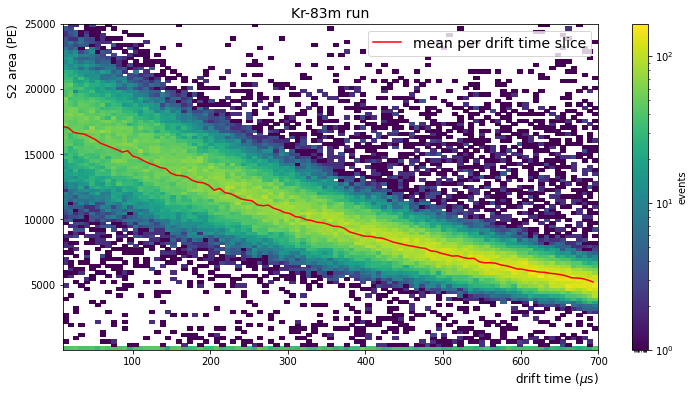

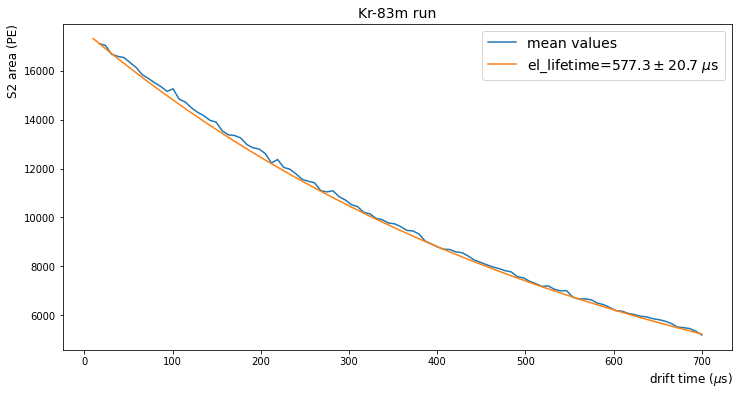

In [12]:
amplitude, tau = electron_lifetime(run_Kr)

In [13]:
def plot_r2_z(run):
    ev = st.get_array(run,'event_info')
    r2=ev['x']*ev['x']+ev['y']*ev['y']
    ph_r2z = Histdd(r2, ev['z'],bins=(np.linspace(0, 2500, 200), np.linspace(-100, 1, 200)))
    ph_xy = Histdd(ev['x'], ev['y'],bins=(np.linspace(-52, 52, 200), np.linspace(-52, 52, 200)))
    plt.figure(figsize=(12,6))
    ph_r2z.plot(log_scale=True,cblabel='events')
    plt.xlabel(r"r^2 (cm^2)", ha='right', x=1)
    plt.ylabel("z (cm)", ha='right', y=1)
    plt.figure(figsize=(10,8))
    ph_xy.plot(log_scale=True,cblabel='events')
    plt.xlabel("x (cm)", ha='right', x=1)
    plt.ylabel("y (cm)", ha='right', y=1)

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

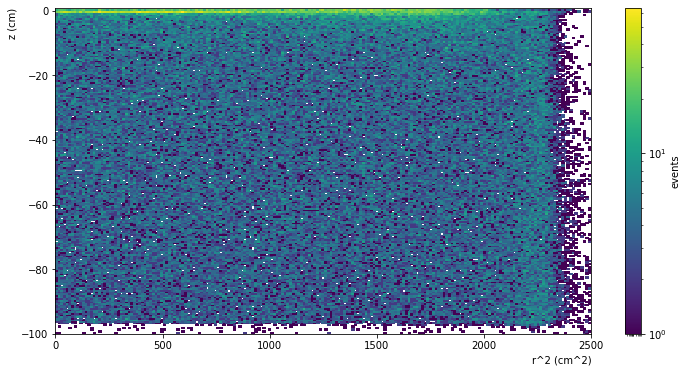

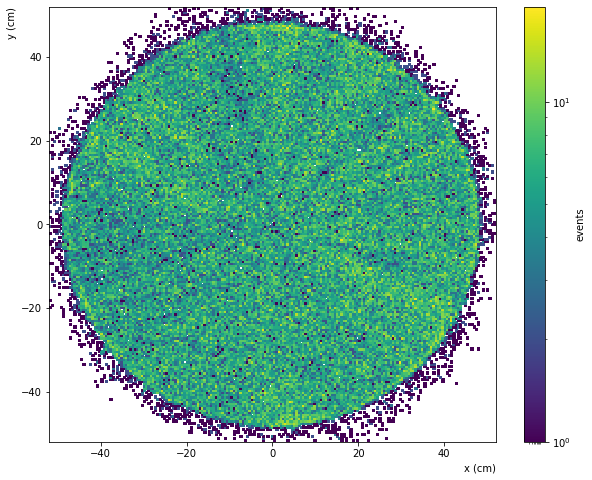

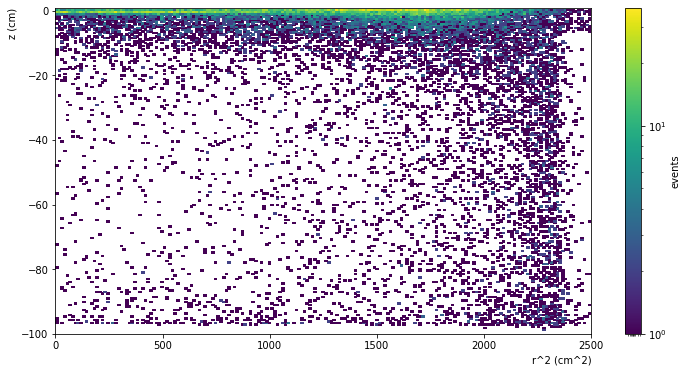

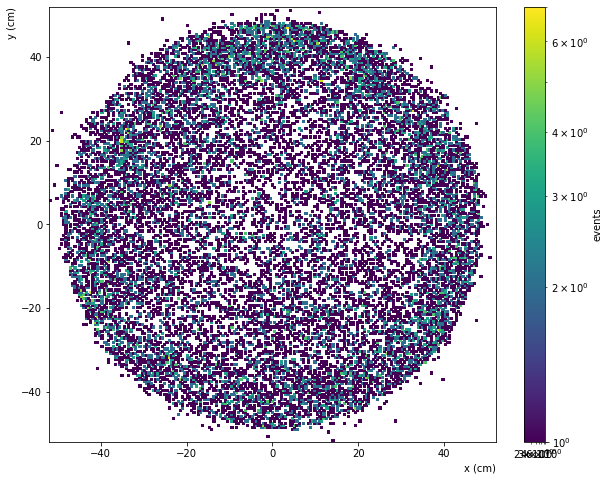

In [14]:
plot_r2_z(run_Kr)
plot_r2_z(run_bkg)

# S2 position correction

In [96]:
def plot_s2_spectrum(events,dr2=[0,5]):
    #events = st.get_array(run_Kr,'event_info',progress_bar=False)
    ev = events[(events['r']*events['r']>dr2[0])&(events['r']*events['r']<dr2[1])]
    hs2,bs2 = np.histogram(ev['s2_area']*(1-ev['s2_area_fraction_top']),
                           bins=np.linspace(1e3, 1e4, 200))
    s2_max = bs2[np.where(hs2==np.max(hs2))[0][0]]
    plt.plot(bs2[1:],hs2,label=f'x={dr2[0]} y={dr2[1]} S2_max = {s2_max}')
    plt.xlabel("S2 bottom (PE)", ha='right', x=1)
    plt.ylabel("counts", ha='right', y=1)
    #plt.xscale('log')
    plt.legend()
    #popt, pcov = curve_fit(gauss, bs2[1:],hs2)
    #perr = np.sqrt(np.diag(pcov))
    return s2_max

Loading event_info: |          | 0.00 % [00:00<?]

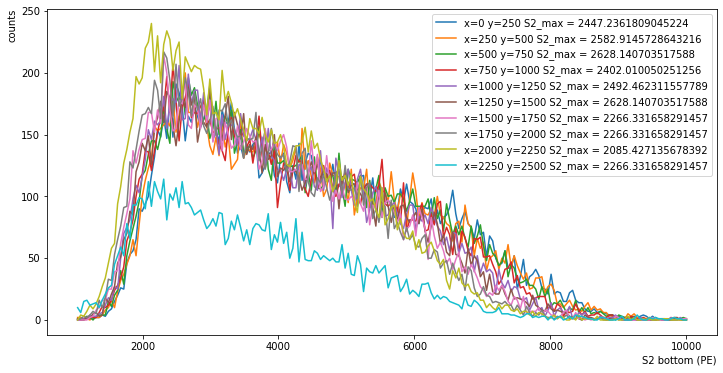

In [97]:
events = st.get_array(run_Kr,'event_info')
plt.figure(figsize=(12,6))
for i in range(10):
    dr2 = [int(i*250),int((i+1)*250)]
    s2_max = plot_s2_spectrum(events,dr2=dr2 )

In [ ]:
# per l'S2 usi il piani (x,y) mentre per S1 si usa r^2 vs z 
S1(r^2,z)=S10 * M(r2,z) #quello che vuoi ottenere è S10
#

In [15]:
def energy_spectrum(run,elim=(0,100),bins=300):
    events = st.get_array(run,'event_info')
    w =0.0137 #keV
    g1 = 0.1442 #PE/ph
    g2 = 11.52 #PE/e 
    cS1 = events['cs1']
    cS2 = events['cs2']*(1-events['s2_area_fraction_top'])
    #ccS2 = events_kr['s2_a_area'][i] * np.exp(events_kr['drift_time'][i]/1000/tau)
    E = w * (cS1/g1+cS2/g2)
    #Ec = w * (cS1/g1+ccS2/g2)
    hE = Hist1d(E, bins=(np.linspace(elim[0],elim[1], bins)))
    #hEc = Hist1d(Ec, bins=(np.logspace(1,6, 300)))
    plt.figure(figsize=(12,6))
    hE.plot(label='corrected')
    #hEc.plot(label='corrected now')
    plt.xlabel("energy (keV)", ha='right', x=1)
    plt.ylabel("counts", ha='right', y=1)
    #plt.xscale('log')
    plt.yscale('log')
    #plt.legend(fontsize=14)

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

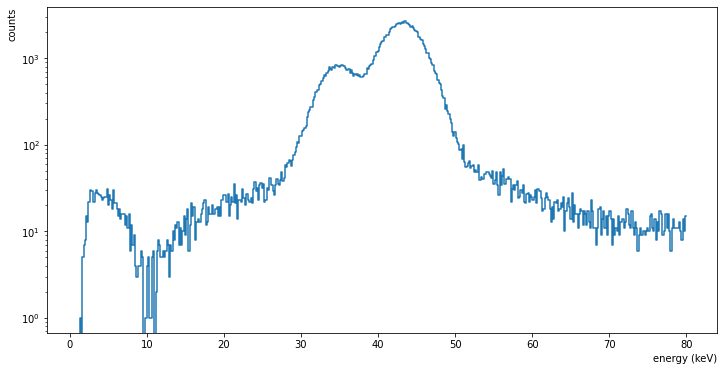

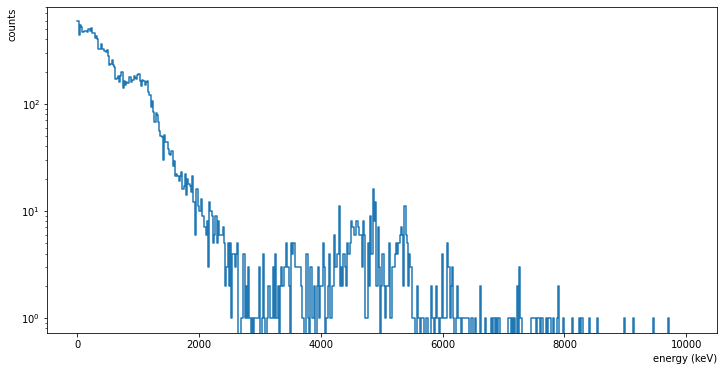

In [20]:
energy_spectrum(run_Kr,elim=(1,80),bins=500)
energy_spectrum(run_bkg,elim=(0,1e4),bins=500)

In [24]:
def save_txt_file(run_id,datatype='background'):
    events = st.get_array(run_id,'event_info')
    print('Number of events',len(events))
    c = [events['s1_area'], events['s2_area'],
         events['s1_range_50p_area'],events['s2_range_50p_area'],
         events['s1_area_fraction_top'],events['s2_area_fraction_top'],
         events['drift_time']/1000,
         events['x'],events['y'],events['z']]
    with open(datatype+"_data.txt", "w") as file:
        for x in zip(*c):
            file.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}\t{9}\n".format(*x))

In [27]:
save_txt_file(run_bkg,datatype='background')

Loading event_info: |          | 0.00 % [00:00<?]

Number of events 19340


In [29]:
save_txt_file(run_Kr,datatype='Kr83m_0')

Loading event_info: |          | 0.00 % [00:00<?]

Number of events 168565


In [31]:
kr_runs = ['170206_1355','170206_1455','170206_1555','170206_1656','170206_1749',
           '170206_1849','170206_1949','170206_2049','170206_2150','170206_2250',
           '170206_2350','170207_0050','170207_0150','170207_0251','170207_0351']
#57     170207_0451
#58     170207_0551
#59     170207_0751
#60     170207_1735
#61     170207_1836
#62     170207_1936
#63     170207_2036
#64     170207_2136
#65     170207_2236
#66     170207_2337
#67     170208_0037
#68     170208_0137
#69     170208_0237
#70     170208_0337
#139    170607_0919

In [33]:
for i in range(5):
    save_txt_file(kr_runs[i],datatype=f'Kr83m_{i}')

Loading event_info: |          | 0.00 % [00:00<?]

Number of events 168565


Loading event_info: |          | 0.00 % [00:00<?]

Number of events 183546


Loading event_info: |          | 0.00 % [00:00<?]

Number of events 193484


Loading event_info: |          | 0.00 % [00:00<?]

Number of events 151358


Loading event_info: |          | 0.00 % [00:00<?]

Number of events 292748
